# Business Case
Metastasis is the spread of cancer cells to new areas of the body, often by way of the lymph system or bloodstream. A metastatic cancer, or metastatic tumor, is one that has spread from the primary site of origin, or where it started, into different areas of the body.

Tumors formed from cells that have spread are called secondary tumors. The cancer may have spread to areas near the primary site, called regional metastasis, or to parts of the body that are farther away, called distant metastasis.

Cancer that has spread from the primary, or original, site to other places in the body is generally classified as advanced cancer. When the cancer has spread only to nearby tissues or lymph nodes, it is called locally advanced cancer. When the cancer has spread to other parts of the body, it is called metastatic cancer. The liver, lungs, lymph nodes and bones are common areas of metastasis.

Even when metastatic cancer spreads to a new location, it is still named after the area of the body where it started. For example, a person with breast cancer that has spread to the bones is said to have breast cancer with bone metastases. If a cancer has spread widely throughout the body before it is discovered and it is unknown exactly where it started, it is called cancer of unknown primary origin.

One of the most important tests when someone is diagnosed with metastatic breast cancer is a tumor biopsy. A biopsy is the removal of a small amount of tissue for examination under a microscope. A biopsy can be done for many parts of the body, including lymph nodes, lungs, liver, bone, skin, or body fluids.

The process is time consuming and always a chance for a human error. As a part of the biopsy test, a small part of the tissue is put on a glass slide under a microscope for the pathologist to examine. Then the pathologist scans through the region to find malignant areas.

# ML Problem Statement
With the current day technology. The glass slides under a microscope can be made digital. The  dataset consisted of 220,025 image patches with Metastatic negative and positive. The main goal of the model is accuratly identifying in order to help clinical tast and save time and reduce error.


# Metastatic Model

## Dataset
We will use Kaggle's version of the PCam (PatchCamelyon) dataset. It's part of the Histopathologic Cancer Detection competition where the challenge is to identify metastatic tissue in histopathologic scans of lymph node sections.

The dataset consists of 220,025 image patches of size 96x96 (130,908 Metastatic negative and 89,117 Metastatic positive).

The images are in tiff format. Many web browsers, including Chrome, don't support the tiff format. Thus the web app wil not be able to accept tiff images. Before training, we will convert these images to png format. This will ensure that the model will be trained on images of similar quality to what we expect a user to submit.
Source - https://www.kaggle.com/vbookshelf/part-2-breast-cancer-analyzer-web-app

### Required Libraries and Files

In [4]:
import tensorflow
from numpy.random import seed
seed(106)
tensorflow.random.set_seed(106)
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
#From the dataset feed we know there is a class imbalance.
#To counter that we will take our sample size as 85000
SAMPLE_SIZE = 85000 

# Files that are available

In [6]:
os.listdir('histopathologic-cancer-detection')

['train_labels.csv', '.DS_Store', 'test', 'train', 'sample_submission.csv']

In [7]:
#Number of Images in train and test
print(len(os.listdir('histopathologic-cancer-detection/train')))
print(len(os.listdir('histopathologic-cancer-detection/test')))

220025
57458


In [9]:
#Creating a data frame containing all images
df_data = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

#As per https://www.kaggle.com/vbookshelf/part-2-breast-cancer-analyzer-web-app
# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220023, 2)


## Class Imbalance
As mentioned earlier checking for class distribution

In [10]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()
    

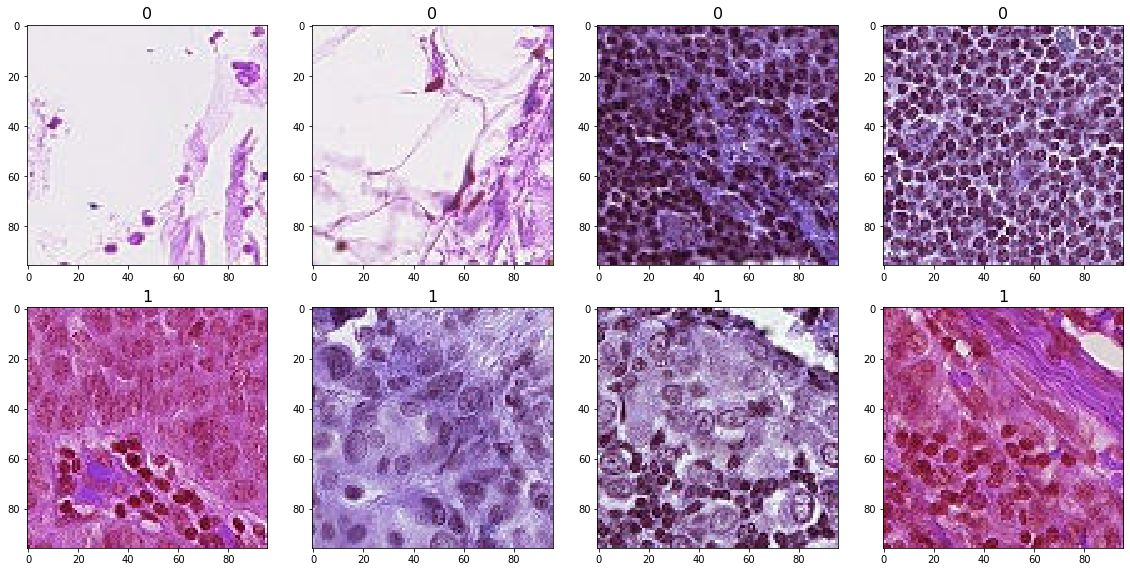

In [11]:
IMAGE_PATH = 'histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

## Creating Train and Validation datasets
Frim train we will be creating validation datasets

In [12]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [14]:
# What is the class distribution?

df_data['label'].value_counts()

0    130907
1     89116
Name: label, dtype: int64

Since class 1's are 89116 and class o's are 130907 we will reduce class 1's to aviod classimablance. In order to achive this I have defined my sample size as 85000

In [15]:
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    85000
0    85000
Name: label, dtype: int64

Now Dataframe df_data consists of equal number of class 1's and 0's

In [16]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(136000, 2)
(34000, 2)


In [17]:
df_train['label'].value_counts()

1    68000
0    68000
Name: label, dtype: int64

In [18]:
df_val['label'].value_counts()

1    17000
0    17000
Name: label, dtype: int64

# Directory Structure
As this is a classification problem, and in order to train the model better. I will be creating direcotries

In [19]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_met_tissue
    # b_has_met_tissue

# val_dir
    # a_no_met_tissue
    # b_has_met_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_met_tissue = os.path.join(train_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(train_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)


# create new folders inside val_dir
no_met_tissue = os.path.join(val_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(val_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)

In [20]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_met_tissue', 'b_has_met_tissue']

# Image Transfer
Transfering images into respective folders

In [21]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [25]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname_tif = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    
    # source path to image
    src = os.path.join('histopathologic-cancer-detection/train', fname_tif)
    # change the new file name to png
    fname_png = image + '.png'
    # destination path to image
    dst = os.path.join(train_dir, label, fname_png)

    
    # read the file as an array
    cv2_image = cv2.imread(src)
    # save the image at the destination as a png file
    cv2.imwrite(dst, cv2_image)
 


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname_tif = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    

    # source path to image
    src = os.path.join('histopathologic-cancer-detection/train', fname_tif)
    # change the new file name to png
    fname_png = image + '.png'
    # destination path to image
    dst = os.path.join(val_dir, label, fname_png)

    
    # read the file as an array
    cv2_image = cv2.imread(src)
    # save the image at the destination as a png file
    cv2.imwrite(dst, cv2_image)


In [26]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_met_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_met_tissue')))

68001
68001


In [27]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_met_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_met_tissue')))

17000
17000


# Mode Buidling

## Image Augumentation

In [28]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [29]:
datagen = ImageDataGenerator(rescale=1.0/255,rotation_range=15,zoom_range=[0.9, 1.25],brightness_range=[0.5, 1.5],height_shift_range=0.1)


train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 136000 images belonging to 2 classes.
Found 34000 images belonging to 2 classes.
Found 34000 images belonging to 2 classes.


In [30]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
#fourth_filters = 256



dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, strides = 1, padding = "same", activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, strides = 1, padding = "same", activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, strides = 1, padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, strides = 1, padding = "same", activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, strides = 1, padding = "same", activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, strides = 1, padding = "same", activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, strides = 2, padding = "same", activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, strides = 2, padding = "same", activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, strides = 2, padding = "same", activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))



model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        3

In [31]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [32]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_met_tissue': 0, 'b_has_met_tissue': 1}


In [35]:
filepath = "Metastatic_Model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
13599/13600 [============================>.] - ETA: 0s - loss: 0.3610 - accuracy: 0.8431
Epoch 00001: val_accuracy improved from -inf to 0.85635, saving model to Metastatic_Model.h5
13600/13600 [==============================] - 4873s 358ms/step - loss: 0.3610 - accuracy: 0.8431 - val_loss: 0.3306 - val_accuracy: 0.8564
Epoch 2/10
13599/13600 [============================>.] - ETA: 0s - loss: 0.3250 - accuracy: 0.8610
Epoch 00002: val_accuracy improved from 0.85635 to 0.87044, saving model to Metastatic_Model.h5
13600/13600 [==============================] - 4878s 359ms/step - loss: 0.3250 - accuracy: 0.8610 - val_loss: 0.2963 - val_accuracy: 0.8704
Epoch 3/10
13599/13600 [============================>.] - ETA: 0s - loss: 0.3018 - accuracy: 0.8722
Epoch 00003: val_accuracy improved from 0.87044 to 0.88738, saving model to Metastatic_Model.h5
13600/13600 [==============================] - 4873s 358ms/step - loss: 0.3018 - accuracy: 0.8723 - val_loss: 0.2679 - val_accuracy: 0.

In [36]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [37]:
# Here the best epoch will be used.

model.load_weights('Metastatic_Model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.213540935480198
val_acc: 0.9144118


<Figure size 432x288 with 0 Axes>

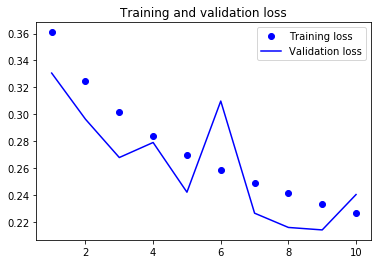

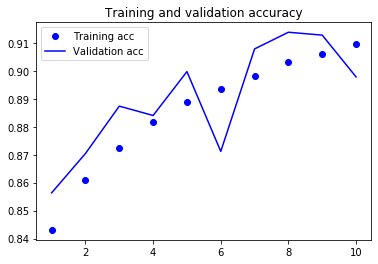

<Figure size 432x288 with 0 Axes>

In [39]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Prediction on Val set

In [40]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

34000/34000 [==============================] - 593s 17ms/step


In [41]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_met_tissue': 0, 'b_has_met_tissue': 1}

In [42]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_met_tissue', 'has_met_tissue'])

df_preds.head()

,no_met_tissue,has_met_tissue
0,0.982293,0.017707
1,0.988207,0.011793
2,0.980404,0.019596
3,0.986494,0.013506
4,0.789523,0.210477


In [43]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_met_tissue']

## What is the AUC Score?

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9707840224913493

## Confusion Matrix

In [45]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [46]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [47]:
test_labels.shape

(34000,)

In [48]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [49]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_met_tissue': 0, 'b_has_met_tissue': 1}

Confusion matrix, without normalization
[[15449  1551]
 [ 1381 15619]]


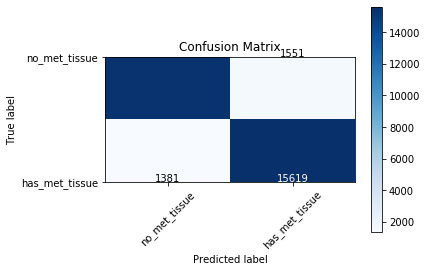

In [50]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_met_tissue', 'has_met_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [51]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

                precision    recall  f1-score   support

 no_met_tissue       0.92      0.91      0.91     17000
has_met_tissue       0.91      0.92      0.91     17000

      accuracy                           0.91     34000
     macro avg       0.91      0.91      0.91     34000
  weighted avg       0.91      0.91      0.91     34000



# Citation
https://www.cancercenter.com/metastasis
https://www.cancer.net/cancer-types/breast-cancer-metastatic/diagnosis